# Swirl correction
The purpose of the project is to identify and correct the portion of the input image affected by a moderate swirl effect.

The center, radius and intensity of the swirl is variable.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import swirl, resize
from skimage.draw import disk
from tensorflow.keras import layers, models
import tensorflow as tf
import tensorflow_datasets as tfds

2025-07-08 13:37:18.059662: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-08 13:37:18.062484: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-08 13:37:18.070995: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751974638.086117    9544 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751974638.090381    9544 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751974638.101249    9544 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

We work on a medium resolution dataset of natural images

In [2]:
def load_flowers_dataset(num_samples=1000, img_size=128):
    ds = tfds.load('tf_flowers', split='train', shuffle_files=True)
    ds = ds.map(lambda x: tf.image.resize(x['image'], (img_size, img_size)) / 255.0)
    ds = ds.take(num_samples).batch(num_samples)
    images = next(iter(ds)).numpy()
    return images

In [3]:
# === CONFIGURATION ===
IMG_SIZE = 128
DEFECT_RADIUS = 32  # max pixel radius of swirl defect
STRENGTH = 4 #max swirl strength

Let us slightly reduce

In [4]:
def preprocess_image(sample):
    """Resize and normalize image"""
    image = tf.image.resize(sample['image'], (IMG_SIZE, IMG_SIZE))
    image = tf.cast(image, tf.float32) / 255.0
    return image

The following function generate a different swirl effect for each image.

In [5]:
def generate_swirl_defect(image_np):
    h, w = image_np.shape[:2]
    radius = int(DEFECT_RADIUS * np.random.uniform(0.5, 1.))
    strength = STRENGTH * np.random.uniform(0.5, 1.)
    center = np.random.randint(radius, h - radius, size=2)
    swirled = swirl(image_np, center=center[::-1], strength=strength, radius=radius)
    mask = np.zeros((h, w, 1), dtype=np.uint8)
    rr, cc = disk(center, radius, shape=(h, w))
    mask[rr, cc] = 1
    return swirled.astype(np.float32), mask

Here is a simple generator. Feel free to adapt it to your needs.
*   you cannot pass the mask as input to the network (but you may try to predict it, if you want)
*   you may regenerate the swirl dynamically at each epoch for data augmentation priurposes, if required.



In [6]:
# === DATA GENERATOR ===
class SwirlDefectGenerator(tf.keras.utils.Sequence):
    def __init__(self, images, batch_size=32, shuffle=True, res="all"):
        self.images = images
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = np.arange(len(images))
        if self.shuffle:
            np.random.shuffle(self.indices)
        self.res = res

    def __len__(self):
        return len(self.images) // self.batch_size

    def __getitem__(self, idx):
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_clean = self.images[batch_indices]
        batch_defected = []
        batch_masks = []
        for img in batch_clean:
            swirled, mask = generate_swirl_defect(img)
            batch_defected.append(swirled)
            batch_masks.append(mask)
        if self.res == "all":
            return np.array(batch_defected), np.array(batch_masks), np.array(batch_clean)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

In [7]:
# === LOAD & SPLIT FLOWER DATA ===
def load_flower_dataset_splits(num_train=3000, num_val=300, num_test=370):
    ds = tfds.load('tf_flowers', split='train', shuffle_files=True)
    ds = ds.map(preprocess_image) #.take(num_train + num_val + num_test)
    all_images = tf.stack(list(ds))
    print(len(all_images))
    return (
        all_images[:num_train].numpy(),
        all_images[num_train:num_train + num_val].numpy(),
        all_images[num_train + num_val:num_train + num_val + num_test].numpy()
    )

In [8]:
train_imgs, val_imgs, test_imgs = load_flower_dataset_splits()

train_gen = SwirlDefectGenerator(train_imgs, batch_size=32,res="all")
val_gen = SwirlDefectGenerator(val_imgs, batch_size=32, res="all")
test_gen = SwirlDefectGenerator(test_imgs, batch_size=32,res="all")

2025-07-08 13:37:19.799594: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
2025-07-08 13:37:19.926011: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:387] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2025-07-08 13:37:20.817595: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-07-08 13:37:20.951638: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 721551360 exceeds 10% of free system memory.


3670


(32, 128, 128, 3)


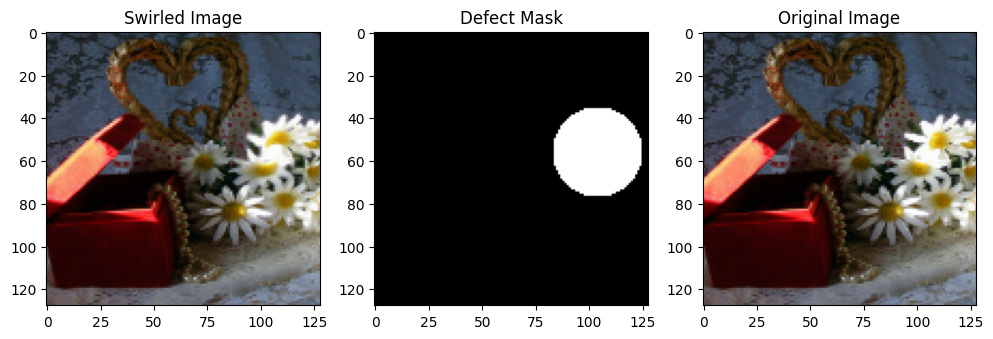

In [9]:
# Sanity check
idx = np.random.randint(0, len(test_gen) - 1)
x_batch, y_mask, y_clean = test_gen[idx]
print(y_clean.shape)
y_clean = y_clean[:,:,:,0:3]

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(x_batch[0])
plt.title("Swirled Image")

plt.subplot(1, 3, 2)
plt.imshow(y_mask[0].squeeze(), cmap='gray')
plt.title("Defect Mask")

plt.subplot(1, 3, 3)
plt.imshow(y_clean[0])
plt.title("Original Image")
plt.show()


# My Network

In [10]:
# Check for GPU availability
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"Using GPU: {gpus}")
else:
    print("No GPU found. Using CPU.")


No GPU found. Using CPU.


In [ ]:
from tensorflow.keras import layers, Model

# Two networks pipeline: the first one predicts the defect mask, the second one tries to correct the defect.

# Architectures

# Mask Predictor
def build_mask_unet(input_shape=(IMG_SIZE, IMG_SIZE, 3)):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    c1 = layers.Conv2D(32, 3, activation="relu", padding="same")(inputs)
    c1 = layers.Conv2D(32, 3, activation="relu", padding="same")(c1)
    p1 = layers.MaxPool2D()(c1)

    c2 = layers.Conv2D(64, 3, activation="relu", padding="same")(p1)
    c2 = layers.Conv2D(64, 3, activation="relu", padding="same")(c2)
    p2 = layers.MaxPool2D()(c2)

    c3 = layers.Conv2D(128, 3, activation="relu", padding="same")(p2)
    c3 = layers.Conv2D(128, 3, activation="relu", padding="same")(c3)

    # Decoder
    u1 = layers.UpSampling2D()(c3)
    u1 = layers.Concatenate()([u1, c2])
    u1 = layers.Conv2D(64, 3, activation="relu", padding="same")(u1)
    u1 = layers.Conv2D(64, 3, activation="relu", padding="same")(u1)

    u2 = layers.UpSampling2D()(u1)
    u2 = layers.Concatenate()([u2, c1])
    u2 = layers.Conv2D(32, 3, activation="relu", padding="same")(u2)
    u2 = layers.Conv2D(32, 3, activation="relu", padding="same")(u2)

    outputs = layers.Conv2D(1, 1, activation="sigmoid")(u2)

    model = models.Model(inputs, outputs, name="MaskUNet")
    return model


def build_swirl_correction_model(
    input_shape_image=(IMG_SIZE, IMG_SIZE, 3), input_shape_mask=(IMG_SIZE, IMG_SIZE, 1)
):
    # Inputs
    input_img = layers.Input(shape=input_shape_image, name="swirled_image")
    input_mask = layers.Input(shape=input_shape_mask, name="predicted_mask")

    # Concatenate inputs along the channel axis -> (H, W, 4)
    x = layers.Concatenate(axis=-1)([input_img, input_mask])

    # Encoder
    c1 = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    c1 = layers.Conv2D(64, 3, activation="relu", padding="same")(c1)
    p1 = layers.MaxPooling2D()(c1)

    c2 = layers.Conv2D(128, 3, activation="relu", padding="same")(p1)
    c2 = layers.Conv2D(128, 3, activation="relu", padding="same")(c2)
    p2 = layers.MaxPooling2D()(c2)

    c3 = layers.Conv2D(256, 3, activation="relu", padding="same")(p2)
    c3 = layers.Conv2D(256, 3, activation="relu", padding="same")(c3)
    p3 = layers.MaxPooling2D()(c3)

    # Bottleneck
    b = layers.Conv2D(512, 3, activation="relu", padding="same")(p3)
    b = layers.Conv2D(512, 3, activation="relu", padding="same")(b)

    # Decoder
    u3 = layers.UpSampling2D()(b)
    u3 = layers.Concatenate()([u3, c3])
    c4 = layers.Conv2D(256, 3, activation="relu", padding="same")(u3)
    c4 = layers.Conv2D(256, 3, activation="relu", padding="same")(c4)

    u2 = layers.UpSampling2D()(c4)
    u2 = layers.Concatenate()([u2, c2])
    c5 = layers.Conv2D(128, 3, activation="relu", padding="same")(u2)
    c5 = layers.Conv2D(128, 3, activation="relu", padding="same")(c5)

    u1 = layers.UpSampling2D()(c5)
    u1 = layers.Concatenate()([u1, c1])
    c6 = layers.Conv2D(64, 3, activation="relu", padding="same")(u1)
    c6 = layers.Conv2D(64, 3, activation="relu", padding="same")(c6)

    # Output: 3-channel corrected image
    output = layers.Conv2D(3, 1, activation="sigmoid", name="corrected_image")(c6)

    model = models.Model(
        inputs=[input_img, input_mask], outputs=output, name="SwirlCorrectionModel"
    )
    return model


# Build the mask predictor model
mask_model = build_mask_unet(input_shape=(IMG_SIZE, IMG_SIZE, 3))
mask_model.summary()

# Build the swirl correction model
correction_model = build_swirl_correction_model(
    input_shape_image=(IMG_SIZE, IMG_SIZE, 3), input_shape_mask=(IMG_SIZE, IMG_SIZE, 1)
)
correction_model.summary()

Model: "MaskUNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      9,248 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │     36,928 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    147,584 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 64, 64,    │          0 │ conv2d_5[0][0]    │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64, 64,    │          0 │ up_sampling2d[0]… │
│ (Concatenate)       │ 192)              │            │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 64, 64,    │    110,656 │ concatenate[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 64, 64,    │     36,928 │ conv2d_6[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 128, 128,  │          0 │ conv2d_7[0][0]    │
│ (UpSampling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 128, 128,  │          0 │ up_sampling2d_1[… │
│ (Concatenate)       │ 96)               │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 128, 128,  │     27,680 │ concatenate_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 128, 128,  │      9,248 │ conv2d_8[0][0]  

 Total params: 471,553 (1.80 MB)

 Trainable params: 471,553 (1.80 MB)

 Non-trainable params: 0 (0.00 B)

Model: "SwirlCorrectionModel"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ swirled_image       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ predicted_mask      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 128, 128,  │          0 │ swirled_image[0]… │
│ (Concatenate)       │ 4)                │            │ predicted_mask[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 128, 128,  │      2,368 │ concatenate_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 128, 128,  │     36,928 │ conv2d_11[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 64, 64,    │          0 │ conv2d_12[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 64, 64,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 64, 64,    │    147,584 │ conv2d_13[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 32, 32,    │          0 │ conv2d_14[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 32, 32,    │    295,168 │ max_pooling2d_3[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 32, 32,    │    590,080 │ conv2d_15[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 16, 16,    │          0 │ conv2d_16[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_4[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 16, 16,    │  2,359,808 │ conv2d_17[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_2     │ (None, 32, 32,    │          0 │ conv2d_18[0][0]   │
│ (UpSampling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 32, 32,    │          0 │ up_sampling2d_2[… │
│ (Concatenate)       │ 768)              │            │ conv2d_16[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 32, 32,    │  1,769,728 │ concatenate_3[0]

 Total params: 7,783,619 (29.69 MB)

 Trainable params: 7,783,619 (29.69 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# TRAINING
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def wrap_generator_for_fit_maskpredictor_model(generator):
    """Wrap generator to return (x, mask) for model.fit"""

    class Wrapped(tf.keras.utils.Sequence):
        def __init__(self, base):
            self.base = base

        def __len__(self):
            return len(self.base)

        def __getitem__(self, idx):
            x, mask, clean = self.base[idx]
            # x: (B, H, W, 3), mask: (B, H, W, 1)
            return x, mask  # model expects 2 inputs

        def on_epoch_end(self):
            self.base.on_epoch_end()

    return Wrapped(generator)

train_seq_maskpredictor = wrap_generator_for_fit_maskpredictor_model(train_gen)
val_seq_maskpredictor = wrap_generator_for_fit_maskpredictor_model(val_gen)

# Add optional callbacks
callbacks_maskmodel = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ReduceLROnPlateau(patience=2, factor=0.5, verbose=1)
]
# Training Mask Predictor
mask_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
mask_history = mask_model.fit(train_seq_maskpredictor, validation_data=val_seq_maskpredictor, epochs=50, callbacks=callbacks_maskmodel)

2025-07-08 13:37:53.847781: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 268435456 exceeds 10% of free system memory.
2025-07-08 13:37:53.900615: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 402653184 exceeds 10% of free system memory.
2025-07-08 13:37:55.046674: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 402653184 exceeds 10% of free system memory.
2025-07-08 13:37:56.804034: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 268435456 exceeds 10% of free system memory.


 2/93 ━━━━━━━━━━━━━━━━━━━━ 15:40 10s/step - loss: 0.0916 - mae: 0.2613

KeyboardInterrupt: 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


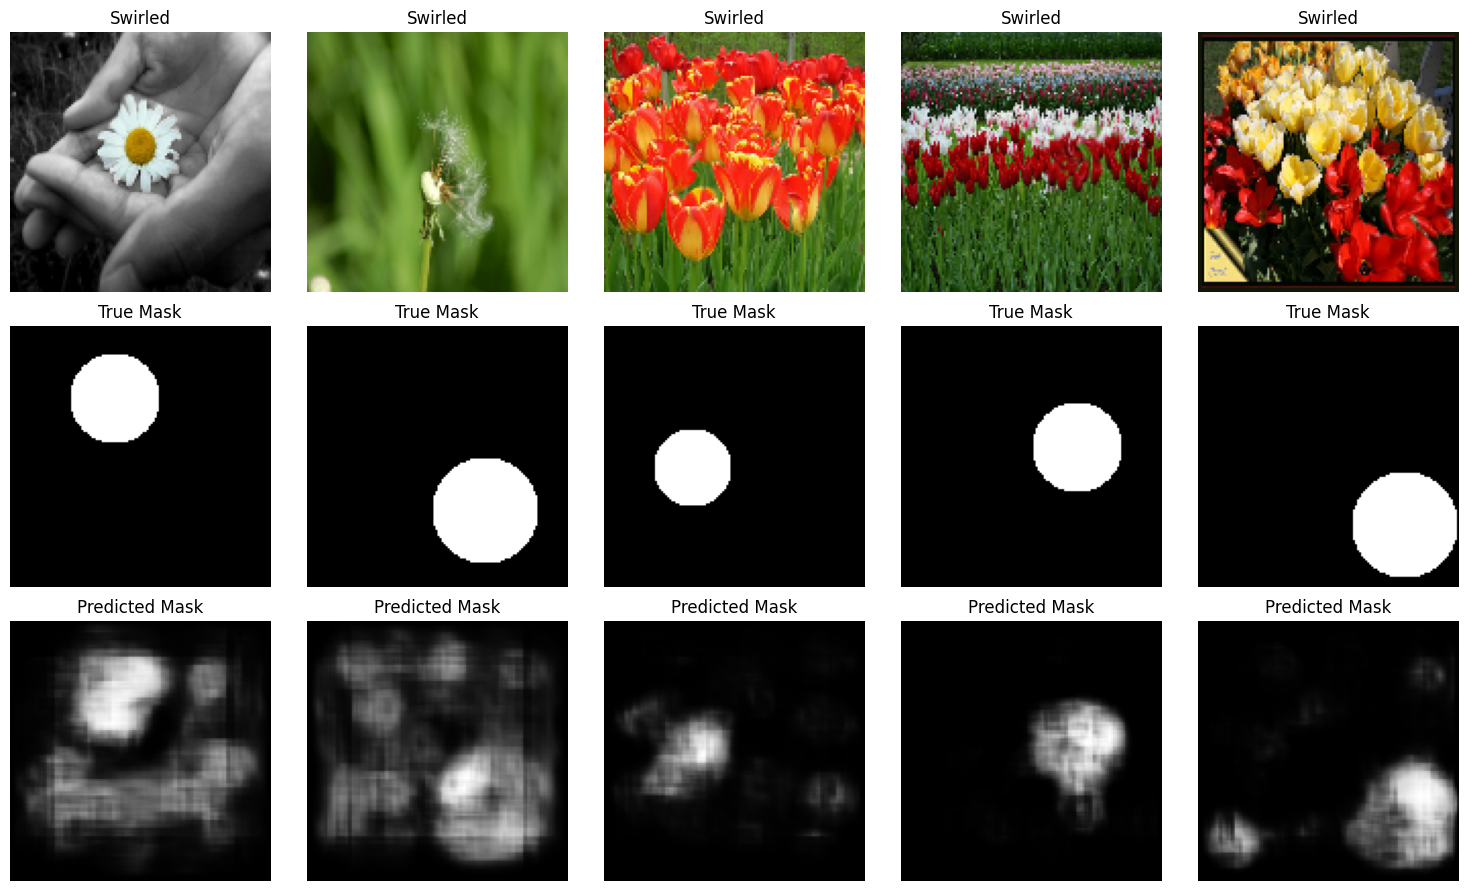

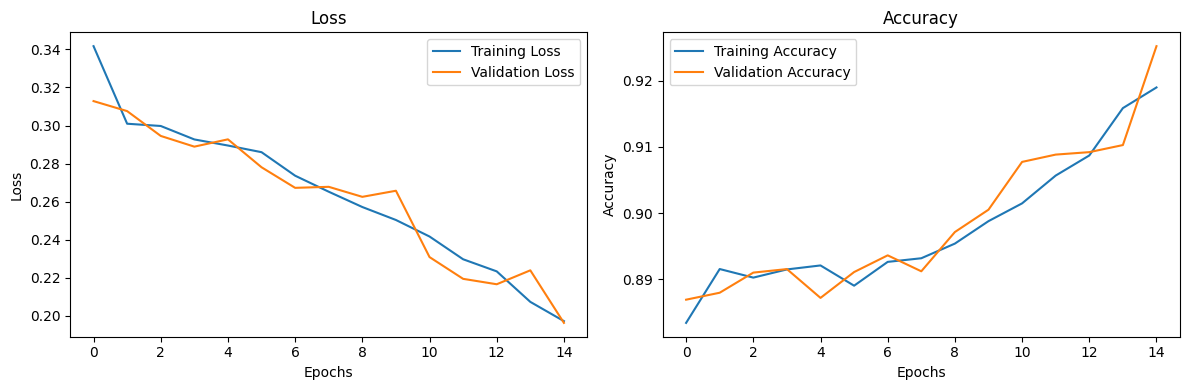

In [219]:
def visualize_mask_predictions(model, data_gen, n=5):
    imgs, true_masks = data_gen[0]
    pred_masks = model.predict(imgs)

    plt.figure(figsize=(n * 3, 9))
    for i in range(n):
        plt.subplot(3, n, i + 1)
        plt.imshow(imgs[i])
        plt.title("Swirled")
        plt.axis('off')

        plt.subplot(3, n, n + i + 1)
        plt.imshow(true_masks[i].squeeze(), cmap='gray')
        plt.title("True Mask")
        plt.axis('off')

        plt.subplot(3, n, 2 * n + i + 1)
        plt.imshow(pred_masks[i].squeeze(), cmap='gray')
        plt.title("Predicted Mask")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

def plot_training_mask(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

visualize_mask_predictions(mask_model, val_seq_maskpredictor, n=5)
plot_training_mask(mask_history)


In [ ]:
# TRAINING SWIRL CORRECTION MODEL
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


def wrap_generator_for_fit_swirlcorrection_model(generator):
    """Wrap SwirlDefectGenerator to return ((x, mask), clean) for model.fit"""

    class Wrapped(tf.keras.utils.Sequence):
        def __init__(self, base):
            self.base = base

        def __len__(self):
            return len(self.base)

        def __getitem__(self, idx):
            x, mask, clean = self.base[idx]
            # x: (B, H, W, 3), mask: (B, H, W, 1)
            return (x, mask), clean  # model expects 2 inputs

        def on_epoch_end(self):
            self.base.on_epoch_end()

    return Wrapped(generator)


train_seq_swirlcorrection = wrap_generator_for_fit_swirlcorrection_model(train_gen)
val_seq_swirlcorrection = wrap_generator_for_fit_swirlcorrection_model(val_gen)

# Add optional callbacks
callbacks_correctionmodel = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ReduceLROnPlateau(patience=2, factor=0.5, verbose=1),
]

# Training Swirl Correction Model
correction_model.compile(optimizer="adam", loss="mse", metrics=["mse", "mae"])
correction_history = correction_model.fit(
    train_seq_swirlcorrection,
    validation_data=val_seq_swirlcorrection,
    epochs=1,
    callbacks=callbacks_correctionmodel,
)

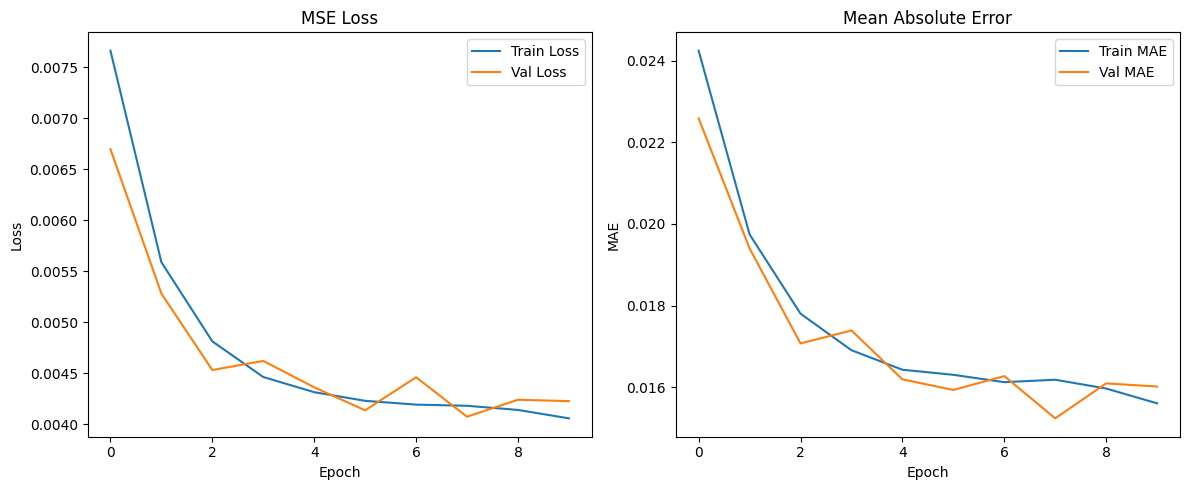

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step


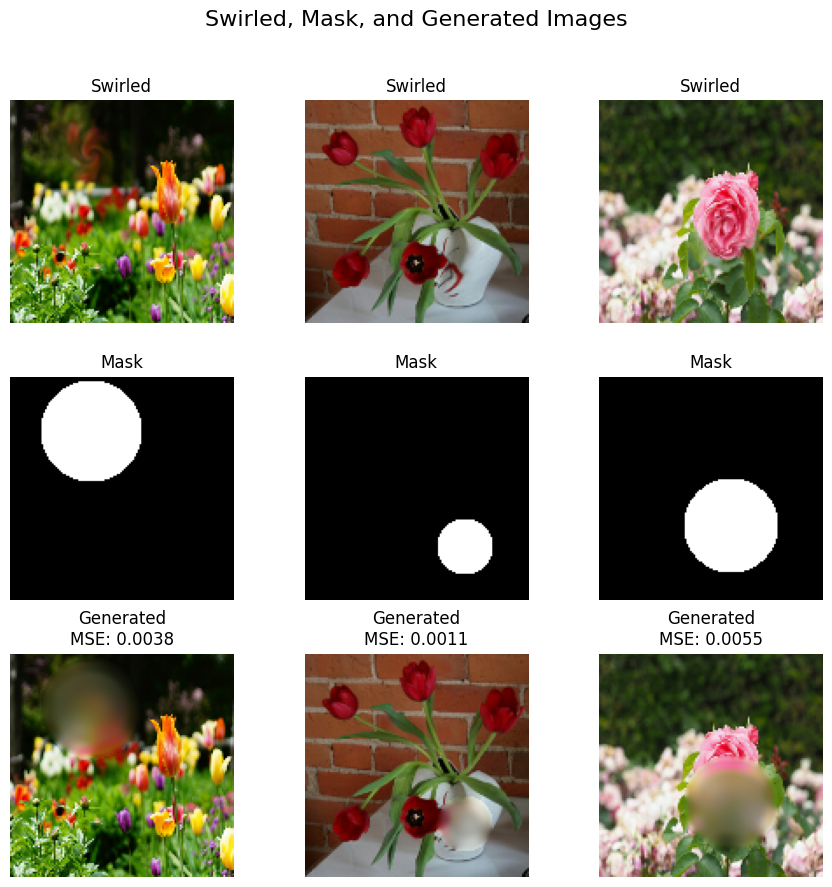

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


# Plot loss and MAE
def plot_training_swirlcorrection(history):
    plt.figure(figsize=(12, 5))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Val Loss")
    plt.title("MSE Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # MAE
    plt.subplot(1, 2, 2)
    plt.plot(history.history["mae"], label="Train MAE")
    plt.plot(history.history["val_mae"], label="Val MAE")
    plt.title("Mean Absolute Error")
    plt.xlabel("Epoch")
    plt.ylabel("MAE")
    plt.legend()

    plt.tight_layout()
    plt.show()


# Visualization of predictions
def visualize_predictions(model, generator, n_samples=5):
    x_batch, y_mask, y_clean = generator[0]
    generated_images = model.predict([x_batch, y_mask])
    generated_mes_batch = np.mean(
        (generated_images - y_clean) ** 2 * y_mask, axis=(1, 2, 3)
    )

    n_samples = min(n_samples, len(x_batch))  # Clamp to batch size

    plt.figure(figsize=(3 * n_samples, 9))

    for i in range(n_samples):
        # Swirled image
        plt.subplot(3, n_samples, i + 1)
        plt.imshow(x_batch[i])
        plt.title("Swirled")
        plt.axis("off")

        # Mask
        plt.subplot(3, n_samples, n_samples + i + 1)
        plt.imshow(y_mask[i].squeeze(), cmap="gray")
        plt.title("Mask")
        plt.axis("off")

        # Generated
        plt.subplot(3, n_samples, 2 * n_samples + i + 1)
        plt.imshow(generated_images[i])
        plt.title(f"Generated\nMSE: {generated_mes_batch[i]:.4f}")
        plt.axis("off")

    plt.tight_layout()
    plt.suptitle("Swirled, Mask, and Generated Images", fontsize=16)
    plt.subplots_adjust(top=0.88)
    plt.show()


# Esegui
plot_training_swirlcorrection(correction_history)
visualize_predictions(correction_model, val_gen, n_samples=3)

As you may see from the examples, the swirl is not always easily identifiable by a human. The network can locate it quite easily (you may try if you like); the actual challenge consists in correcting the effect.

A pipilene of multiple networks may be acceptable. You should not rely on the knowledge that the defect was due to a swirl.

In [ ]:
# Save the models
mask_model.save("mask_predictor.keras")
correction_model.save("swirl_correction.keras")

# Evaluation metric

The generated image should be evaluated ONLY on the region corresponding to the mask. In addition this will be compared with the initial distance introduced by the swirl operation

Let us compute this "initial" error:

In [74]:
# Select a batch from the test generator
idx = np.random.randint(0, len(test_gen) - 1)
x_batch_defected, x_batch_mask, y_batch_clean = test_gen[idx]
# Compute initial distance between swirled image and original for the batch
initial_mse_imgs = np.mean((x_batch_defected - y_batch_clean)**2*x_batch_mask,axis=(1,2,3))
initial_mse_batch = np.mean(initial_mse_imgs)
print(f"Initial error introduced by swilr: {initial_mse_batch:.4f}")

Initial error introduced by swilr: 0.0007


The initial error quite low. To better emphasize the correction we compute the ratio between the resulting error and the initial one.
**This should be a value between 0 (perfect reconstruction) and 1 (no reconstruction). Higher values mean you are doing things worse.**

In [75]:
# Predict the repaired images
generated_images = model.predict([x_batch_defected, x_batch_mask])

# Compute the distance between generated image and original for the batch
generated_mes_batch = np.mean((generated_images - y_batch_clean_img)**2*x_batch_mask,axis=(1,2,3))
# Now let us compute the ratio, and the average over the batch
mean_ratio = np.mean(generated_mes_batch/initial_mse_batch)

print(f"Average score (Generated / Initial): {mean_ratio:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


NameError: name 'y_batch_clean_img' is not defined

Repeat the previous computation for all batches in testing data, and return mean and standard deviation.

In [ ]:
import numpy as np

ratios = []

for idx in range(len(test_gen)):
    x_batch_defected, x_batch_mask, y_batch_clean = test_gen[idx]

    # MSE iniziale swirled vs clean (weighted dal mask)
    initial_mse_imgs = np.mean((x_batch_defected - y_batch_clean)**2 * x_batch_mask, axis=(1,2,3))
    initial_mse_batch = np.mean(initial_mse_imgs)

    # Predict immagini corrette
    generated_images = correction_model.predict([x_batch_defected, x_batch_mask])

    # MSE generato vs clean (weighted dal mask)
    generated_mse_imgs = np.mean((generated_images - y_batch_clean)**2 * x_batch_mask, axis=(1,2,3))

    # Ratio batch (media dei ratio immagini in batch)
    batch_ratios = generated_mse_imgs / initial_mse_imgs  # singole immagini
    mean_batch_ratio = np.mean(batch_ratios)

    ratios.append(mean_batch_ratio)

# Media e deviazione standard su tutti i batch
mean_ratio_all = np.mean(ratios)
std_ratio_all = np.std(ratios)

print(f"Average ratio (Generated / Initial) over test set:")
print(f"MEAN: {mean_ratio_all}")
print(f"STD: {std_ratio_all}")


# Parameters

Try to keep below 4M parameters (total, excluding parameteres of the optimizer).

You have the usual constraints:
* the project should be written in keras
* you should submit a single well documented notebook
* try to give access to weights through gdown


